<a href="https://colab.research.google.com/github/lpanigrahi/coursera/blob/main/ML_specialization/C2_W2_SoftMax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optional Lab - Softmax Function
In this lab, we will explore the softmax function. This function is used in both Softmax Regression and in Neural Networks when solving Multiclass Classification problems.  

<center>  <img  src="https://github.com/lpanigrahi/coursera/blob/main/ML_specialization/images/C2_W2_Softmax_Header.PNG?raw=1" width="600" />  <center/>

  

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

In [3]:
os.chdir(os.path.join(os.getcwd(),'drive/MyDrive/coursera/ML_specialization/C2_W2'))

In [5]:
!pip install ipympl -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.9 MB/s eta 0:00:00


In [6]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from IPython.display import display, Markdown, Latex
from sklearn.datasets import make_blobs
%matplotlib widget
from matplotlib.widgets import Slider
from lab_utils_common import dlc
from lab_utils_softmax import plt_softmax
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

> **Note**: Normally, in this course, the notebooks use the convention of starting counts with 0 and ending with N-1,  $\sum_{i=0}^{N-1}$, while lectures start with 1 and end with N,  $\sum_{i=1}^{N}$. This is because code will typically start iteration with 0 while in lecture, counting 1 to N leads to cleaner, more succinct equations. This notebook has more equations than is typical for a lab and thus  will break with the convention and will count 1 to N.

## Softmax Function
In both softmax regression and neural networks with Softmax outputs, N outputs are generated and one output is selected as the predicted category. In both cases a vector $\mathbf{z}$ is generated by a linear function which is applied to a softmax function. The softmax function converts $\mathbf{z}$  into a probability distribution as described below. After applying softmax, each output will be between 0 and 1 and the outputs will add to 1, so that they can be interpreted as probabilities. The larger inputs  will correspond to larger output probabilities.
<center>  <img  src="https://github.com/lpanigrahi/coursera/blob/main/ML_specialization/images/C2_W2_SoftmaxReg_NN.png?raw=1" width="600" />  

The softmax function can be written:
$$a_j = \frac{e^{z_j}}{ \sum_{k=1}^{N}{e^{z_k} }} \tag{1}$$
The output $\mathbf{a}$ is a vector of length N, so for softmax regression, you could also write:
\begin{align}
\mathbf{a}(x) =
\begin{bmatrix}
P(y = 1 | \mathbf{x}; \mathbf{w},b) \\
\vdots \\
P(y = N | \mathbf{x}; \mathbf{w},b)
\end{bmatrix}
=
\frac{1}{ \sum_{k=1}^{N}{e^{z_k} }}
\begin{bmatrix}
e^{z_1} \\
\vdots \\
e^{z_{N}} \\
\end{bmatrix} \tag{2}
\end{align}


Which shows the output is a vector of probabilities. The first entry is the probability the input is the first category given the input $\mathbf{x}$ and parameters $\mathbf{w}$ and $\mathbf{b}$.  
Let's create a NumPy implementation:

In [7]:
def my_softmax(z):
    ez = np.exp(z)              #element-wise exponenial
    sm = ez/np.sum(ez)
    return(sm)

Below, vary the values of the `z` inputs using the sliders.

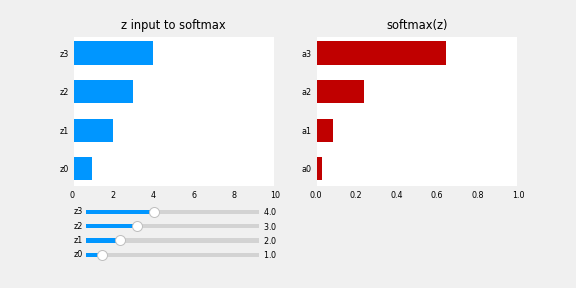

In [8]:
plt.close("all")
plt_softmax(my_softmax)

As you are varying the values of the z's above, there are a few things to note:
* the exponential in the numerator of the softmax magnifies small differences in the values 
* the output values sum to one
* the softmax spans all of the outputs. A change in `z0` for example will change the values of `a0`-`a3`. Compare this to other activations such as ReLU or Sigmoid which have a single input and single output.

## Cost
<center> <img  src="https://github.com/lpanigrahi/coursera/blob/main/ML_specialization/images/C2_W2_SoftMaxCost.png?raw=1" width="400" />    <center/>

The loss function associated with Softmax, the cross-entropy loss, is:
\begin{equation}
  L(\mathbf{a},y)=\begin{cases}
    -log(a_1), & \text{if $y=1$}.\\
        &\vdots\\
     -log(a_N), & \text{if $y=N$}
  \end{cases} \tag{3}
\end{equation}

Where y is the target category for this example and $\mathbf{a}$ is the output of a softmax function. In particular, the values in $\mathbf{a}$ are probabilities that sum to one.
>**Recall:** In this course, Loss is for one example while Cost covers all examples. 
 
 
Note in (3) above, only the line that corresponds to the target contributes to the loss, other lines are zero. To write the cost equation we need an 'indicator function' that will be 1 when the index matches the target and zero otherwise. 
    $$\mathbf{1}\{y == n\} = =\begin{cases}
    1, & \text{if $y==n$}.\\
    0, & \text{otherwise}.
  \end{cases}$$
Now the cost is:
\begin{align}
J(\mathbf{w},b) = -\frac{1}{m} \left[ \sum_{i=1}^{m} \sum_{j=1}^{N}  1\left\{y^{(i)} == j\right\} \log \frac{e^{z^{(i)}_j}}{\sum_{k=1}^N e^{z^{(i)}_k} }\right] \tag{4}
\end{align}

Where $m$ is the number of examples, $N$ is the number of outputs. This is the average of all the losses.


## Tensorflow
This lab will discuss two ways of implementing the softmax, cross-entropy loss in Tensorflow, the 'obvious' method and the 'preferred' method. The former is the most straightforward while the latter is more numerically stable.

Let's start by creating a dataset to train a multiclass classification model.

In [9]:
# make  dataset for example
centers = [[-5, 2], [-2, -2], [1, 2], [5, -2]]
X_train, y_train = make_blobs(n_samples=2000, centers=centers, cluster_std=1.0,random_state=30)

### The *Obvious* organization

The model below is implemented with the softmax as an activation in the final Dense layer.
The loss function is separately specified in the `compile` directive. 

The loss function is `SparseCategoricalCrossentropy`. This loss is described in (3) above. In this model, the softmax takes place in the last layer. The loss function takes in the softmax output which is a vector of probabilities. 

In [10]:
model = Sequential(
    [ 
        Dense(25, activation = 'relu'),
        Dense(15, activation = 'relu'),
        Dense(4, activation = 'softmax')    # < softmax activation here
    ]
)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.001),
)

model.fit(
    X_train,y_train,
    epochs=10
)
        

Epoch 1/10
63/63 [==============================] - 1s 2ms/step - loss: 1.2989
Epoch 2/10
63/63 [==============================] - 0s 2ms/step - loss: 0.6447
Epoch 3/10
63/63 [==============================] - 0s 2ms/step - loss: 0.3415
Epoch 4/10
63/63 [==============================] - 0s 2ms/step - loss: 0.1761
Epoch 5/10
63/63 [==============================] - 0s 2ms/step - loss: 0.0972
Epoch 6/10
63/63 [==============================] - 0s 2ms/step - loss: 0.0651
Epoch 7/10
63/63 [==============================] - 0s 2ms/step - loss: 0.0530
Epoch 8/10
63/63 [==============================] - 0s 2ms/step - loss: 0.0457
Epoch 9/10
63/63 [==============================] - 0s 2ms/step - loss: 0.0416
Epoch 10/10
63/63 [==============================] - 0s 2ms/step - loss: 0.0376


Because the softmax is integrated into the output layer, the output is a vector of probabilities.

In [11]:
p_nonpreferred = model.predict(X_train)
print(p_nonpreferred [:2])
print("largest value", np.max(p_nonpreferred), "smallest value", np.min(p_nonpreferred))

63/63 [==============================] - 0s 2ms/step
[[4.02e-03 6.51e-03 9.81e-01 8.54e-03]
 [9.94e-01 6.22e-03 3.56e-05 2.26e-05]]
largest value 0.9999996 smallest value 8.073037e-10


### Preferred <img align="Right" src="https://github.com/lpanigrahi/coursera/blob/main/ML_specialization/images/C2_W2_softmax_accurate.png?raw=1"  style=" width:400px; padding: 10px 20px ; ">
Recall from lecture, more stable and accurate results can be obtained if the softmax and loss are combined during training.   This is enabled by the 'preferred' organization shown here.


In the preferred organization the final layer has a linear activation. For historical reasons, the outputs in this form are referred to as *logits*. The loss function has an additional argument: `from_logits = True`. This informs the loss function that the softmax operation should be included in the loss calculation. This allows for an optimized implementation.

In [12]:
preferred_model = Sequential(
    [ 
        Dense(25, activation = 'relu'),
        Dense(15, activation = 'relu'),
        Dense(4, activation = 'linear')   #<-- Note
    ]
)
preferred_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  #<-- Note
    optimizer=tf.keras.optimizers.Adam(0.001),
)

preferred_model.fit(
    X_train,y_train,
    epochs=10
)
        

Epoch 1/10
63/63 [==============================] - 1s 2ms/step - loss: 0.6939
Epoch 2/10
63/63 [==============================] - 0s 2ms/step - loss: 0.2229
Epoch 3/10
63/63 [==============================] - 0s 2ms/step - loss: 0.1000
Epoch 4/10
63/63 [==============================] - 0s 2ms/step - loss: 0.0689
Epoch 5/10
63/63 [==============================] - 0s 2ms/step - loss: 0.0546
Epoch 6/10
63/63 [==============================] - 0s 2ms/step - loss: 0.0469
Epoch 7/10
63/63 [==============================] - 0s 2ms/step - loss: 0.0415
Epoch 8/10
63/63 [==============================] - 0s 2ms/step - loss: 0.0381
Epoch 9/10
63/63 [==============================] - 0s 2ms/step - loss: 0.0344
Epoch 10/10
63/63 [==============================] - 0s 2ms/step - loss: 0.0319


#### Output Handling
Notice that in the preferred model, the outputs are not probabilities, but can range from large negative numbers to large positive numbers. The output must be sent through a softmax when performing a prediction that expects a probability. 
Let's look at the preferred model outputs:

In [13]:
p_preferred = preferred_model.predict(X_train)
print(f"two example output vectors:\n {p_preferred[:2]}")
print("largest value", np.max(p_preferred), "smallest value", np.min(p_preferred))

63/63 [==============================] - 0s 2ms/step
two example output vectors:
 [[-2.1  -2.36  3.58 -1.07]
 [ 7.92  2.36 -4.05 -3.91]]
largest value 13.654657 smallest value -8.501735


The output predictions are not probabilities!
If the desired output are probabilities, the output should be be processed by a [softmax](https://www.tensorflow.org/api_docs/python/tf/nn/softmax).

In [14]:
sm_preferred = tf.nn.softmax(p_preferred).numpy()
print(f"two example output vectors:\n {sm_preferred[:2]}")
print("largest value", np.max(sm_preferred), "smallest value", np.min(sm_preferred))

two example output vectors:
 [[3.36e-03 2.60e-03 9.85e-01 9.36e-03]
 [9.96e-01 3.83e-03 6.32e-06 7.23e-06]]
largest value 0.999999 smallest value 4.54909e-09


To select the most likely category, the softmax is not required. One can find the index of the largest output using [np.argmax()](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html).

In [15]:
for i in range(5):
    print( f"{p_preferred[i]}, category: {np.argmax(p_preferred[i])}")

[-2.1  -2.36  3.58 -1.07], category: 2
[ 7.92  2.36 -4.05 -3.91], category: 0
[ 5.61  2.28 -3.03 -3.51], category: 0
[-1.75  4.36 -2.04 -3.54], category: 1
[-1.29 -2.84  5.07 -3.38], category: 2


## SparseCategorialCrossentropy or CategoricalCrossEntropy
Tensorflow has two potential formats for target values and the selection of the loss defines which is expected.
- SparseCategorialCrossentropy: expects the target to be an integer corresponding to the index. For example, if there are 10 potential target values, y would be between 0 and 9. 
- CategoricalCrossEntropy: Expects the target value of an example to be one-hot encoded where the value at the target index is 1 while the other N-1 entries are zero. An example with 10 potential target values, where the target is 2 would be [0,0,1,0,0,0,0,0,0,0].


## Congratulations!
In this lab you 
- Became more familiar with the softmax function and its use in softmax regression and in softmax activations in neural networks. 
- Learned the preferred model construction in Tensorflow:
    - No activation on the final layer (same as linear activation)
    - SparseCategoricalCrossentropy loss function
    - use from_logits=True
- Recognized that unlike ReLU and Sigmoid, the softmax spans multiple outputs.